In [47]:
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from dqn_agent import Agent

In [48]:
def sir_dif(y, t, beta, gamma, u):

## SIR setting
## ds = -beta * S * I - u * S, (u = vaccination rate <= 1)
## dI = beta * S * I - gamma * I
## dR = gamma * I 
## u = action
    S, I = y
    S7 = 0
    I7 = 0
    for t in range(7):
        for i in range(int(1/0.01)): 
            ds = (-beta * S * I - u * S)
            di = (beta * S * I - gamma * I)

            S += ds * 0.01
            I += di * 0.01
        #S7 += S
        #I7 += I

    dydt = np.array([S, I])
    return dydt

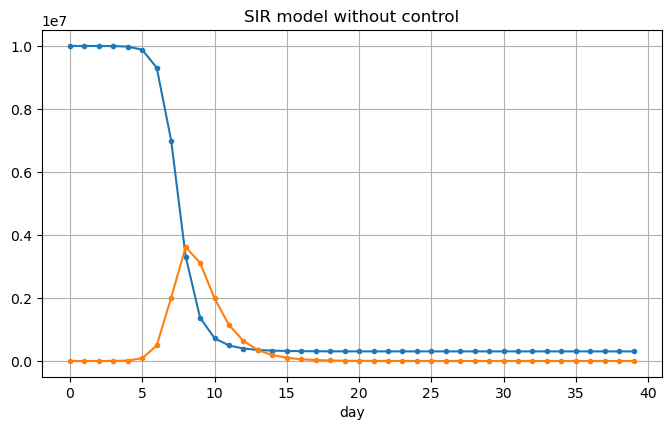

In [53]:
class SirEnvironment:
    def __init__(self, S0=9999990, I0=10):
        # S0 = 990
        # I0 = 10
        # R0 = 0
        # N = 1000
        # beta = 0.002
        # gamma = 0.5

        self.state = np.array([S0, I0])
        self.beta = 0.000000036
        self.gamma = 1/10
        self.nu_daily_max = 500000
        self.nu_total_max = 5000000
        self.nu_min = 0.0
        self.nus = []
        # self.beta = 0.00000007
        # self.gamma = 1/10

    def reset(self, S0=9999990, I0=10):
        self.state = np.array([S0, I0])
        self.beta = 0.000000036
        self.gamma = 1/10
        self.nus = []
        return self.state

    def step(self, action):
        nu = self.nu_min if action == 0 else self.nu_daily_max
        self.nus.append(nu)
        S0, I0 = self.state
        # sol = odeint(df, initial, dt, args = (beta, gamma, action))
        # sol = odeint(sir, [max(0, S0-nu),I0], np.linspace(0, 1, 101), args=(self.beta, self.gamma, action))
        sol_dif = sir_dif([max(0, S0-nu), I0], t, self.beta, self.gamma, action)
        # 계산하고 제일 끝  state가 new
        new_state = sol_dif
        # new state
        S, I = new_state
        # state update
        self.state = new_state

        # reward case
        reward = -I - nu
        if np.sum(self.nus) > self.nu_total_max:
            reward -= 200000
        reward = reward/1e7
        
        # new_state[1] : I < 1.0 이면 멈춤
        done = True if new_state[1] < 1.0 else False
        return (new_state, reward, done, 0)


plt.rcParams['figure.figsize'] = (8, 4.5)

# 1. Without Control
env = SirEnvironment()
state = env.reset()
# t = 300days
max_t = 39
states = state
# action은 없는 상태 why? without control 이니까
actions = []
for t in range(max_t):
    action = 0
    #print(states)
    next_state, reward, done, _ = env.step(action)
    #print(env.step(action))
    # np.vstack : 배열을 세로로 결합, 요소(열) 개수가 일치해야함, 행은 상관 없음
    # np.hstack : 배열을 가로로 결합, 행이 일치해야함, 열 상관없음.
    states = np.vstack((states, next_state))
    #print(states)
    state = next_state
    #print(state)

plt.clf()
plt.plot(range(max_t+1), states[:,0].flatten(), '.-')
plt.plot(range(max_t+1), states[:,1].flatten(), '.-')
plt.grid()
plt.title('SIR model without control')
plt.xlabel('day')
plt.savefig('SIR_wo_control.png', dpi=300)
plt.show(block=False)

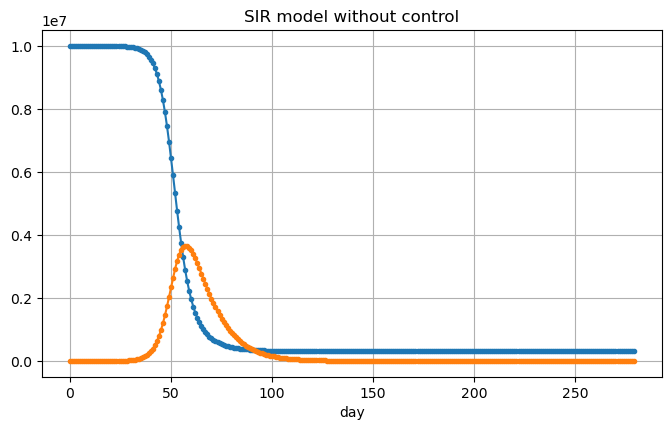

In [50]:
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from dqn_agent import Agent


def sir(y, t, beta, gamma, u):

## SIR setting
## ds = -beta * S * I - u * S, (u = vaccination rate <= 1)
## dI = beta * S * I - gamma * I
## dR = gamma * I 
## u = action

    S, I = y
    dydt = np.array([-beta * S * I - u * S, beta * S * I - gamma * I])
    return dydt


class SirEnvironment:
    def __init__(self, S0=9999990, I0=10):
        # S0 = 990
        # I0 = 10
        # R0 = 0
        # N = 1000
        # beta = 0.002
        # gamma = 0.5

        self.state = np.array([S0, I0])
        self.beta = 0.000000036
        self.gamma = 1/10
        self.nu_daily_max = 500000
        self.nu_total_max = 5000000
        self.nu_min = 0.0
        self.nus = []
        # self.beta = 0.00000007
        # self.gamma = 1/10

    def reset(self, S0=9999990, I0=10):
        self.state = np.array([S0, I0])
        self.beta = 0.000000036
        self.gamma = 1/10
        self.nus = []
        return self.state

    def step(self, action):
        nu = self.nu_min if action == 0 else self.nu_daily_max
        self.nus.append(nu)
        S0, I0 = self.state
        # sol = odeint(df, initial, dt, args = (beta, gamma, action))
        sol = odeint(sir, [max(0, S0-nu),I0], np.linspace(0, 1, 101), args=(self.beta, self.gamma, action))
        # 계산하고 제일 끝  state가 new
        new_state = sol[-1, :]
        # new state
        S, I = new_state
        # state update
        self.state = new_state

        # reward case
        reward = -I - nu
        if np.sum(self.nus) > self.nu_total_max:
            reward -= 200000
        reward = reward/1e7
        
        # new_state[1] : I < 1.0 이면 멈춤
        done = True if new_state[1] < 1.0 else False
        return (new_state, reward, done, 0)


plt.rcParams['figure.figsize'] = (8, 4.5)

# 1. Without Control
env = SirEnvironment()
state = env.reset()
# t = 300days
max_t = 279
states = state
# action은 없는 상태 why? without control 이니까
actions = []
for t in range(max_t):
    action = 0
    #print(states)
    next_state, reward, done, _ = env.step(action)
    #print(env.step(action))
    # np.vstack : 배열을 세로로 결합, 요소(열) 개수가 일치해야함, 행은 상관 없음
    # np.hstack : 배열을 가로로 결합, 행이 일치해야함, 열 상관없음.
    states = np.vstack((states, next_state))
    #print(states)
    state = next_state
    #print(state)

plt.clf()
plt.plot(range(max_t+1), states[:,0].flatten(), '.-')
plt.plot(range(max_t+1), states[:,1].flatten(), '.-')
plt.grid()
plt.title('SIR model without control')
plt.xlabel('day')
plt.savefig('SIR_wo_control.png', dpi=300)
plt.show(block=False)

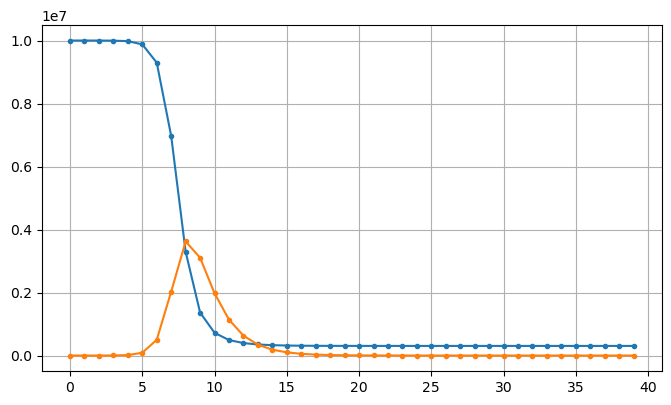

In [52]:
S_ = states[:,0].flatten()
I_ = states[:,1].flatten()
S7 = S_[::7]
I7 = I_[::7]

plt.plot(range(40), S7, '.-')
plt.plot(range(40), I7, '.-')
plt.grid()

In [130]:
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from dqn_agent import Agent
import os
from scipy.io import loadmat
import time
#from numba import jit
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Load the data
current_directory = os.getcwd()
M = loadmat(f'{current_directory}/params.mat')
MV = loadmat(f'{current_directory}/mv.mat')
BE = loadmat(f'{current_directory}/result4init.mat')
#@jit
def update_vaccine(vac_1st, vac_2nd, ind, neg_flag_S, neg_flag_V1, neg_flag_S_hist, neg_flag_V1_hist):
        if np.any(neg_flag_S):
            # Find the vaccination number for age groups having negative states
            vac_num_neg_state = np.sum(vac_1st[ind:, neg_flag_S], axis=1)

           # Compute ratio between other age groups
            neg_flag_S_hist = neg_flag_S_hist | neg_flag_S
            valid_indices = ~neg_flag_S_hist
            vac_1st_valid = vac_1st[ind:, valid_indices]
            sum_vac_1st_valid = np.sum(vac_1st_valid, axis=1, keepdims=True)
            
            # Prevent division by zero
            sum_vac_1st_valid[sum_vac_1st_valid == 0] = 1
            
            ratio = vac_1st_valid / sum_vac_1st_valid

            # Compute vaccination number using the ratio
            vac = vac_num_neg_state[:, np.newaxis] * ratio

            # Deal with NaNs resulting from division by zero
            vac = np.nan_to_num(vac)

            # Update vaccination number for 1st dose
            vac_1st[ind:, ~neg_flag_S_hist] += vac
            vac_1st[ind:, neg_flag_S_hist] = 0

        # Update 2nd vaccination number
        if np.any(neg_flag_V1):
            # Find the vaccination number for age groups having negative states
            vac_num_neg_state = np.sum(vac_2nd[ind:, neg_flag_V1], axis=1)

            # Compute ratio between other age groups
            neg_flag_V1_hist = neg_flag_V1_hist | neg_flag_V1
            valid_indices2 = ~neg_flag_V1_hist
            vac_2nd_valid = vac_2nd[ind:, valid_indices2]
            sum_vac_2nd_valid = np.sum(vac_2nd_valid, axis=1, keepdims=True)
            
            # Prevent division by zero
            sum_vac_2nd_valid[sum_vac_2nd_valid == 0] = 1
            
            ratio = vac_2nd_valid / sum_vac_2nd_valid

            # Compute vaccination number using the ratio
            vac = vac_num_neg_state[:, np.newaxis] * ratio

            # Deal with NaNs
            vac = np.nan_to_num(vac)

            # Update vaccination number for 2nd dose
            vac_2nd[ind:, ~neg_flag_V1_hist] += vac
            vac_2nd[ind:, neg_flag_V1_hist] = 0
        
        return vac_1st, vac_2nd, neg_flag_S_hist, neg_flag_V1_hist

def covid1(y, dt, t_idx, mV1, mV2, e1, e2, kappa, alpha, gamma, vprevf1, vprevf2, fatality_rate, 
          vprevs1, vprevs2, severe_illness_rate, alpha_eff, delta_eff, 
          delta, beta, sd, sc, contact, neg_flag_S_hist, neg_flag_V1_hist):
    '''state size : 13 * 9 = 117
       state size : 14 * 9 (include the new inf)
       WAIFW는 action에 따라 변하므로, action에 따라 움직이게 function안에서 움직여야 함'''
    
    # initial 
    S = y[0:9]
    E = y[9:18]
    I = y[18:27]
    H = y[27:36]
    R = y[36:45]
    V1 = y[45:54]
    V2 = y[54:63]
    EV1 = y[63:72]
    EV2 = y[72:81]
    IV1 = y[81:90]
    IV2 = y[90:99]
    # 실시간 계산을 위한 것
    F = np.zeros(9)
    SI = np.zeros(9)
    new_inf = np.zeros(9)

    ## for flag
    # - Flag check
    neg_flag_S_hist = neg_flag_S_hist.reshape(-1)
    neg_flag_V1_hist = neg_flag_V1_hist.reshape(-1)
    neg_flag_S = np.full((9, 1), False, dtype=bool)
    neg_flag_S = neg_flag_S.reshape(-1)
    neg_flag_V1 = np.full((9, 1), False, dtype=bool)
    neg_flag_V1 = neg_flag_V1.reshape(-1)
    
    # WAIFW
    '''sd = 1 X 440 (440일치 social distancing)
       alpha_eff = 471 X 1 --> constant
       delta_eff = 471 X 1 --> constant
       delta = 1
       beta = 0.0505
       contact = 9X9 (contact matrix)
       변이 : 471일, 사회적 거리두기 일자 : 439일 (시작부터~439까지)
       WAIFW = (471X1)*(1X439)*(9X9)
       WAIFW = 모두 상수 * contact matrix'''
    
    # t_idx parameters --> NO need
    contact[1,1] = contact[1,1] * sc
    
    # WAIFW
    # delta + alpha effect
    mix_eff = alpha_eff + (delta * delta_eff)    
    WAIFW = mix_eff * beta * sd * contact

    # main loop

    mv1 = mV1[t_idx,:]
    mv2 = mV2[t_idx,:]
   #======================= for 1day ===================#
    for _ in range(int(1/dt)):
      # Calculate the lambda
      sumI = I + IV1 + IV2

      # labmda = 9X1
      lambdaS = np.matmul(WAIFW, sumI) * S
      WAIFWV1 = WAIFW * (1-e1)
      lambdaV1 = np.dot(WAIFWV1, sumI) * V1
      WAIFWV2 = WAIFW * (1-e2)
      lambdaV2 = np.dot(WAIFWV2, sumI) * V2

      # age flow (단기라서 없음)
   
      
      # Difference equations
      '''시간에 따른 parameter : mV1, mV2 
      연령에 따른 parmater : lambda, fatality_rate, severe_illness_rate
      e1, e2 : Vaccine eff (constant)
      alpha, delta : 변이 비율 (contant)
      kappa:
      gamma:
      mV1, mV2 : number of vaccination'''
      S_next = S + (- lambdaS - mv1) * dt
      E_next = E + (lambdaS - kappa * E) * dt
      I_next = I + (kappa * E - alpha * I) * dt
      H_next = H + (alpha * (I + IV1 + IV2) - gamma * H) * dt
      R_next = R + (gamma * H) * dt
      V1_next = V1 + (mv1 - lambdaV1 - mv2) * dt 
      V2_next = V2 + (mv2 - lambdaV2) * dt
      EV1_next = EV1 + (lambdaV1 - kappa * EV1) * dt
      EV2_next = EV2 + (lambdaV2 - kappa * EV2) * dt
      IV1_next = IV1 + (kappa * EV1 - alpha * IV1) * dt
      IV2_next = IV2 + (kappa * EV2 - alpha * IV2) * dt
      F = F + dt * (alpha * (I + (1 - vprevf1) * IV1 + (1 - vprevf2) * IV2) * fatality_rate) 
      SI = SI + dt * (alpha * (I + (1 - vprevs1)* IV1 + (1 - vprevs2) * IV2) * severe_illness_rate)
      new_inf = new_inf + dt * (alpha *((I + IV1 + IV2) + (I_next+ IV1_next + IV2_next))) / 2

      S = S_next
      E = E_next
      I = I_next
      H = H_next
      R = R_next
      V1 = V1_next
      V2 = V2_next
      EV1 = EV1_next
      EV2 = EV2_next
      IV1 = IV1_next
      IV2 = IV2_next

      # negtive flag check
      if np.any(S < 0) or np.any(V1 < 0):
            neg_flag_S = S < 0
            neg_flag_V1 = V1 < 0
            break

    if np.any(neg_flag_S) or np.any(neg_flag_V1):
      mV1, mV2, neg_flag_S_hist, neg_flag_V1_hist = update_vaccine(mV1, mV2, t_idx, neg_flag_S, neg_flag_V1, 
                                                                  neg_flag_S_hist, neg_flag_V1_hist)
      y_ = covid1(y, dt, t_idx, mV1, mV2, e1, e2, kappa, alpha, gamma, vprevf1, vprevf2, fatality_rate, 
      vprevs1, vprevs2, severe_illness_rate, alpha_eff, delta_eff, delta, beta, sd, sc, contact, neg_flag_S_hist, neg_flag_V1_hist)
   
      S = y_[0:9]
      E = y_[9:18]
      I = y_[18:27]
      H = y_[27:36]
      R = y_[36:45]
      V1 = y_[45:54]
      V2 = y_[54:63]
      EV1 = y_[63:72]
      EV2 = y_[72:81]
      IV1 = y_[81:90]
      IV2 = y_[90:99]
      F = y_[99:108]
      SI = y_[108:117]
      new_inf = y_[117:126]
   #======================= for 1day ===================#

    #print(lambdaS)
    dydt = np.array([S, E, I, H, R, V1, V2, EV1, EV2, IV1, IV2, F, SI, new_inf])
    dydt = dydt.reshape(1,-1)[0]
    return dydt

#@jit
def covid7(y, dt, t_idx, mV1, mV2, e1, e2, kappa, alpha, gamma, vprevf1, vprevf2, fatality_rate, 
          vprevs1, vprevs2, severe_illness_rate, alpha_eff, delta_eff, 
          delta, beta, sd, sc, contact, neg_flag_S_hist, neg_flag_V1_hist):
    '''state size : 13 * 9 = 117
       state size : 14 * 9 (include the new inf)
       WAIFW는 action에 따라 변하므로, action에 따라 움직이게 function안에서 움직여야 함'''
    
    # initial 
    S = y[0:9]
    E = y[9:18]
    I = y[18:27]
    H = y[27:36]
    R = y[36:45]
    V1 = y[45:54]
    V2 = y[54:63]
    EV1 = y[63:72]
    EV2 = y[72:81]
    IV1 = y[81:90]
    IV2 = y[90:99]
    # 실시간 계산을 위한 것
    F = y[99:108]
    SI = y[108:117]
    new_inf = y[117:126]

    ## for flag
    # - Flag check
    neg_flag_S_hist = neg_flag_S_hist.reshape(-1)
    neg_flag_V1_hist = neg_flag_V1_hist.reshape(-1)
    neg_flag_S = np.full((9, 1), False, dtype=bool)
    neg_flag_S = neg_flag_S.reshape(-1)
    neg_flag_V1 = np.full((9, 1), False, dtype=bool)
    neg_flag_V1 = neg_flag_V1.reshape(-1)
    
    # WAIFW
    '''sd = 1 X 440 (440일치 social distancing)
       alpha_eff = 471 X 1 --> constant
       delta_eff = 471 X 1 --> constant
       delta = 1
       beta = 0.0505
       contact = 9X9 (contact matrix)
       변이 : 471일, 사회적 거리두기 일자 : 439일 (시작부터~439까지)
       WAIFW = (471X1)*(1X439)*(9X9)
       WAIFW = 모두 상수 * contact matrix'''
    
    # t_idx parameters --> NO need
    contact[1,1] = contact[1,1] * sc
    
    # WAIFW
    # delta + alpha effect
    mix_eff = alpha_eff + (delta * delta_eff)    
    WAIFW = mix_eff * beta * sd * contact

    # main loop
    for i in range(7):
        t_idx_ = (t_idx*7) + i
        y1 = covid1(y, dt, t_idx_, mV1, mV2, e1, e2, kappa, alpha, gamma, vprevf1, vprevf2, fatality_rate, 
            vprevs1, vprevs2, severe_illness_rate, alpha_eff, delta_eff, delta, beta, sd, sc, contact, neg_flag_S_hist, neg_flag_V1_hist)
        y = y1

        S = y[0:9]
        E = y[9:18]
        I = y[18:27]
        H = y[27:36]
        R = y[36:45]
        V1 = y[45:54]
        V2 = y[54:63]
        EV1 = y[63:72]
        EV2 = y[72:81]
        IV1 = y[81:90]
        IV2 = y[90:99]
        F = y[99:108]
        SI = y[108:117]
        new_inf = y[117:126]

    #print(lambdaS)
    dydt = np.array([S, E, I, H, R, V1, V2, EV1, EV2, IV1, IV2, F, SI, new_inf])
    dydt = dydt.reshape(1,-1)[0]
    return dydt

class covidEnvironment:
    def __init__(self):
        # initial
        self.S0 = BE['S0'][:,0]
        self.E0 = BE['E0'][:,0]
        self.I0 = BE['I0'][:,0]
        self.H0 = BE['H0'][:,0]
        self.R0 = BE['R0'][:,0]
        self.V10 = BE['V10'][:,0]
        self.V20 = BE['V20'][:,0]
        self.EV10 = BE['EV10'][:,0]
        self.IV10 = BE['IV10'][:,0]
        self.EV20 = BE['EV20'][:,0]
        self.IV20 = BE['EV10'][:,0]
        self.new_inf0 = np.zeros(9)
        self.F0 = np.zeros(9)
        self.SI0 = np.zeros(9)
        # self.mV1 = BE['MV1']
        # self.mV2 = BE['MV2']
        self.mV1 = MV['mv1'][259:,:]
        self.mV2 = MV['mv2'][259:,:]
        
        # parameters
        self.beta = M['beta'][0][0]
        self.kappa = M['kappa'][0][0]
        self.alpha = M['alpha'][0][0]
        self.gamma = M['gamma'][0][0]
        self.delta = M['delta'][0][0]
        self.fatality_rate = M['fatality_rate'][0]
        self.severe_illness_rate =  M['severe_illness_rate'][0]
        self.vprevs1 = M['vprevs'][0][0]
        self.vprevs2 = M['vprevs'][0][1]
        self.vprevf1 = M['vprevf'][0][0]
        self.vprevf2 = M['vprevf'][0][1]
        self.alpha_eff = 0.03
        self.delta_eff = 0.97
        self.contact = M['contact']
        self.e1 = 0.3326
        self.e2 = 0.7770
        self.sc = 1
        self.dt = 0.01

        # action space
        self.sds = []

        # others
        self.tf = 26
        self.dt = 0.01
        self.time = 0
        self.days = [self.time]
        self.his = np.array([self.S0, self.E0, self.I0, self.H0, self.R0,
                             self.V10, self.V20, self.EV10, self.EV20, 
                             self.IV10, self.IV20, self.F0, self.SI0, self.new_inf0])
        self.hist = self.his.reshape(1,-1)[0]
        self.history = [self.hist]
        self.lambdas = []
        self.rewards = []

    def reset(self):
        self.state = np.array([self.S0, self.E0, self.I0, self.H0, self.R0,
                             self.V10, self.V20, self.EV10, self.EV20, 
                             self.IV10, self.IV20, self.F0, self.SI0, self.new_inf0])
        self.state = self.state.reshape(1,-1)[0]

        # parameters
        self.beta = M['beta'][0][0]
        self.kappa = M['kappa'][0][0]
        self.alpha = M['alpha'][0][0]
        self.gamma = M['gamma'][0][0]
        self.delta = M['delta'][0][0]
        self.fatality_rate = M['fatality_rate'][0]
        self.severe_illness_rate =  M['severe_illness_rate'][0]
        self.vprevs1 = M['vprevs'][0][0]
        self.vprevs2 = M['vprevs'][0][1]
        self.vprevf1 = M['vprevf'][0][0]
        self.vprevf2 = M['vprevf'][0][1]
        self.alpha_eff = 0.03
        self.delta_eff = 0.97
        self.contact = M['contact']
        self.e1 = 0.3326
        self.e2 = 0.7770
        self.sc = 1
        self.dt = 0.01

        # action space

        self.rewards = []
        self.history = [self.state]
        return self.state

    def step(self, action, t_idx):
        # action value change
        # (4th 3rd 2nd 1st)
        sd = [0.4402, 0.4402*1.4, 0.4402*(1.4**2), 1]
        sd = sd[action]

        # nu = self.nu_min if action == 0 else self.nu_daily_max
        # self.nus.append(nu)
        # t_idx paramter
        # -flag
        neg_flag_S_hist = np.full((9, 1), False, dtype=bool)
        neg_flag_V1_hist = np.full((9, 1), False, dtype=bool)
        # state
        y0 = self.state
        y0 = y0.reshape(1,-1)[0]
        sol = covid7(y0, self.dt, t_idx, self.mV1, self.mV2,
                    self.e1, self.e2, self.kappa, self.alpha, self.gamma, 
                    self.vprevf1, self.vprevf2, self.fatality_rate, self.vprevs1,self.vprevs2, self.severe_illness_rate, 
                    self.alpha_eff, self.delta_eff, self.delta, self.beta, sd, self.sc, self.contact, neg_flag_S_hist, neg_flag_V1_hist)
        new_state = sol

        # new state
        S = new_state[0:9]
        E = new_state[9:18]
        I = new_state[18:27]
        H = new_state[27:36]
        R = new_state[36:45]
        V1 = new_state[45:54]
        V2 = new_state[54:63]
        EV1 = new_state[63:72]
        EV2 = new_state[72:81]
        IV1 = new_state[81:90]
        IV2 = new_state[90:99]
        F = new_state[99:108]
        SI = new_state[108:117]
        new_inf = new_state[117:126]

        # state update
        self.state = new_state

        # reward case
        # 실험용 : newinf + severecase + Fatalitycase
        reward = - (np.sum(I)) / 5000

        self.rewards.append(reward)
        self.days.append(self.time)
        self.history.append(new_state)
        
        # new_state[1] : I < 1.0 이면 멈춤
        done = True if self.time >= self.tf else False
        return (new_state, reward, done, {})


In [ ]:
#@jit


In [132]:
# 1. Without Control
env = covidEnvironment()
state = env.reset()
# t = 440days
max_t = 26
states = state.reshape(1,-1)[0]
st = time.time()
score = 0
for t_idx in range(max_t):
    action = 0
    next_state, reward, done, _ = env.step(action, t_idx)
    # np.vstack : 배열을 세로로 결합, 요소(열) 개수가 일치해야함, 행은 상관 없음
    # np.hstack : 배열을 가로로 결합, 행이 일치해야함, 열 상관없음.
    states = np.vstack((states, next_state))
    state = next_state
    score =+ reward

et = time.time()
print("time :", et-st, "초")
print(score)

S = np.sum(states[:,0:9],1)
E = np.sum(states[:,9:18],1)
I = np.sum(states[:,18:27],1)
H = np.sum(states[:,27:36],1)
R = np.sum(states[:,36:45],1)
V1 = np.sum(states[:,45:54],1)
V2 = np.sum(states[:,54:63],1)
EV1 = np.sum(states[:,63:72],1)
EV2 = np.sum(states[:,72:81],1)
IV1 = np.sum(states[:,81:90],1)
IV2 = np.sum(states[:,90:99],1)
F = np.sum(states[:,99:108],1)
SI = np.sum(states[:,108:117],1)
new_inf = np.sum(states[:,117:126],1)



time : 0.8318300247192383 초
-9.630466793636666e-05


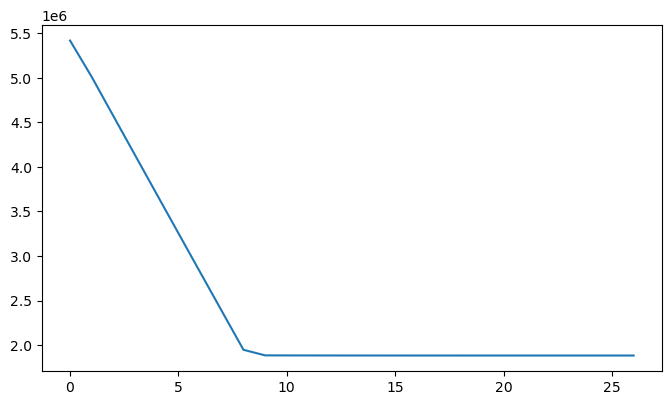

In [133]:
plt.plot(S)

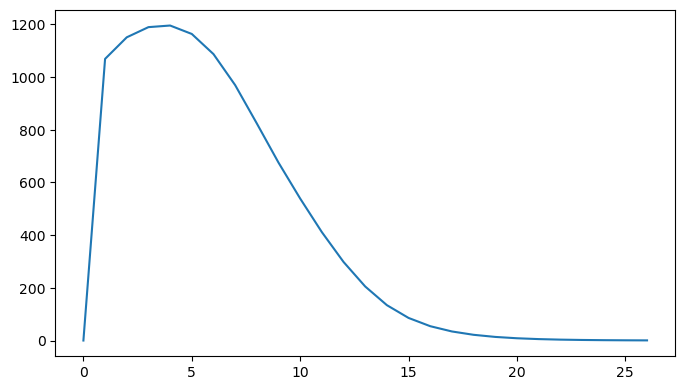

In [137]:
plt.plot(new_inf)

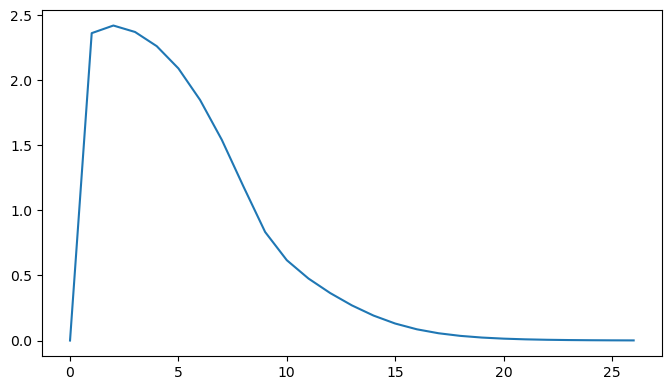

In [138]:
plt.plot(SI)


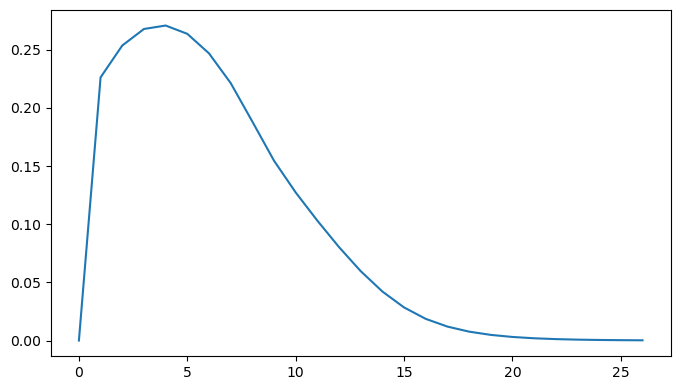

In [139]:
plt.plot(F)

In [92]:
result = loadmat(f'{current_directory}/result.mat')
S_ = result['SS'][0]
E_ = result['EE'][0]
I_ = result['II'][0]
H_ = result['HH'][0]
R_ = result['RR'][0]
V1_ = result['VV1'][0]
V2_ = result['VV2'][0]
EV1_ = result['EVV1'][0]
EV2_ = result['EVV2'][0]
IV1_ = result['IVV1'][0]
IV2_ = result['IVV2'][0]
F_ = result['FF'][0]
SI_ = result['SII'][0]
new_inf_ = result['new_inf_'][0]

In [93]:
S_ = S_[260:]
E_ = E_[260:]
I_ = I_[260:]
H_ = H_[260:]
R_ = R_[260:]
V1_ = V1_[260:]
V2_ = V2_[260:]
EV1_ = EV1_[260:]
EV2_ = EV2_[260:]
IV1_ = IV1_[260:]
IV2_ = IV2_[260:]
F_ = F_[259:]
SI_ = SI_[259:]
new_inf_ = new_inf_[259:]



In [94]:
S7 = S_[::7]
E7 = E_[::7]
I7 = I_[::7]
H7 = H_[::7]
R7 = R_[::7]
V17 = V1_[::7]
V27 = V2_[::7]
EV17 = EV1_[::7]
EV27 = EV2_[::7]
IV17 = IV1_[::7]
IV27 = IV2_[::7]
F7 = F_[::7]
SI7 = SI_[::7]
new_inf7 = new_inf_[::7]

In [95]:
S7.shape

(26,)

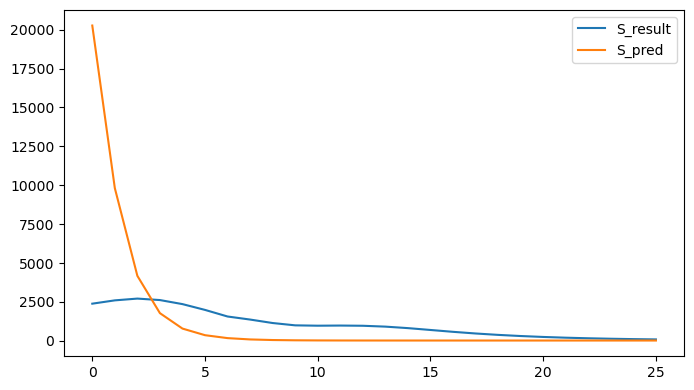

In [127]:
# plot 비교
plt.clf()
plt.plot(range(26), I7, label='S_result')
plt.plot(range(26), I, label='S_pred')
plt.legend()
plt.savefig('S.png', dpi=300)



In [87]:
range(7)

range(0, 7)